In [1]:
import os
import pandas as pd
import numpy as np
from astropy import units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import uncertainties as uncer
import uncertainties.umath as umath

%matplotlib widget

def ClearData():
    data = {'Name': [],
    'z': [], 
    'class_name': [],
    'alpha': [],
    'alphaRad': [],
    'alphaK': [],
    'alphaRadK': []
      }
    return data

In [ ]:
#######################################################################################################
### spectral index fitting
#######################################################################################################
df = ClearData()

Xmatch = pd.read_csv('/Users/87steven/Documents/ASIAA/Blazar SED code and data/data/BZCAT_Xmatch_ACC_csv.csv') # # = 37671

#for i in range(0, 1): # 1367
for i, Dataname in enumerate( list(set(Xmatch.name)) ):  
    # specify index in [], to start on certain sources ("if kernal stopped acciently")
    # if kernal have been restart, specify certain in [] will not start on the index which stopped
    
    #######################################################################################################
    ### test source name and initial setting parameters
    #######################################################################################################
    #Dataname = 'J1323-3407'
    #Dataname = 'J0111+3906'
    #Dataname = 'J0324-2918' # good spectral index fitting example source
    #Dataname = 'J0854+2006' # good spectral index fitting example source
    plotfigure = 0
    
    print('i = ', i, ', source name = ', Dataname)
    #######################################################################################################
    ### get redshift information from Xmatch 
    #######################################################################################################
    index = np.where( Xmatch == Dataname )[0]
    Xmatch_z = Xmatch['z'].values
    Xmatch_Class = Xmatch['Class'].values

    z = Xmatch_z[index[0]]
    cla = Xmatch_Class[index[0]]
    
    #######################################################################################################
    ### Read file of the source (freq, flux, flux error)
    #######################################################################################################
    Table = pd.read_csv('/Users/87steven/Documents/ASIAA/Blazar SED code and data/source individual flux/' + Dataname + '_flux.csv')    
    
    freq = Table['freq'].values       
    flux = Table['flux'].values           
    flux_err = Table['flux_err'].values                                    
        
    #######################################################################################################
    ### extract flux density 
    #######################################################################################################
    ### set flux error which is nan to 0.01
    fluxerr_nan = np.where( np.isnan(flux_err ))[0]
    flux_err[fluxerr_nan] = 0.01
    ### find flux index which is not nan
    flux_NOTnan = np.where( (~np.isnan(flux)) & (flux > 0) )[0]
    ### save new data into array
    freq = freq[flux_NOTnan]
    Fnu = flux[flux_NOTnan]
    #flux_err = flux_err[flux_NOTnan]
    
    ### select radio to sub-mm freq and Fnu
    radio_mm_index = np.where(freq <= 7.0E11)[0]
    radio_mm_Freq = freq[radio_mm_index]
    radio_mm_Fnu = Fnu[radio_mm_index]

    ### select radio ONLY freq and Fnu
    radio_index = np.where( (freq >= 1.0E7) & (freq <= 4.0E9))[0]
    radio_Freq = freq[radio_index]
    radio_Fnu = Fnu[radio_index]
    
    ### frequency correction of radio to sub-mm freq
    radio_mm_FreqK = freq[radio_mm_index]  #*(1+z)
    
    ### frequency ccorrection of radio freq
    radio_FreqK = freq[radio_index]  #*(1+z)
    
    #######################################################################################################
    ### Spectral index fitting
    #######################################################################################################
    ### define fitting function
    def func(y, a, C):
        return C+y*(a)

    ### spectral index fitting (radio to sub-mm) "Before K-correction" 
    if len(radio_mm_Freq) > 3:
        p0 = [ 0]
        #p0 = [0, 0]
        popt, pcov = curve_fit(func, np.log10(radio_mm_Freq), np.log10(radio_mm_Fnu)) #  , p0 = p0,  maxfev = 100*(len(radio_mm_Freq)+1)
        yfit = func(np.log10(radio_mm_Freq), *popt)
    
        alpha = '%7.5f' % float(popt[0])
    else:
        popt = [np.nan, np.nan]
        alpha = np.nan
        yfit = np.empty(len(radio_mm_Freq))
        yfit[:] = np.nan
        
    if len(radio_Freq) > 3:
        p0 = [ 0]
        #p0 = [0, 0]
        poptRad, pcovRad = curve_fit(func, np.log10(radio_Freq), np.log10(radio_Fnu))  # maxfev = 100*(len(radio_Freq)+1)
        yfitRad = func(np.log10(radio_Freq), *poptRad)
    
        alphaRad = '%7.5f' % float(poptRad[0])
    else: 
        poptRad = [np.nan, np.nan]
        alphaRad = np.nan
        yfitRad = np.empty(len(radio_Freq))
        yfitRad[:] = np.nan
        
    #######################################################################################################
    ### K-corrected spectral index fitting (using radio-mm spectral index) 
    #######################################################################################################    
    ### spectral index fitting (radio to sub-mm)  "After K-correction"         
    radio_mm_FnuK = Fnu[radio_mm_index]*(1+z)**(1-float(alpha))  # (2-float(alpha))
    
    if len(radio_mm_FreqK) > 3:
        p0 = [0]
        poptK, pcov = curve_fit(func, np.log10(radio_mm_FreqK), np.log10(radio_mm_FnuK)) 
        yfitK = func(np.log10(radio_mm_FreqK), *poptK)
        
        alphaK = '%7.5f' % float(poptK[0])
    else:
        poptK = [np.nan, np.nan]
        alphaK = np.nan
        yfitK = np.empty(len(radio_mm_FreqK))
        yfitK[:] = np.nan
    
    ### spectral index fitting (radio ONLY)  "After K-correction" 
    radio_FnuK = Fnu[radio_index]*(1+z)**(1-float(alphaRad))  # (2-float(alphaRad))
    
    if len(radio_FreqK) > 3:
        p0 = [0]
        poptRadK, pcov = curve_fit(func, np.log10(radio_FreqK), np.log10(radio_FnuK))
        yfitRadK = func(np.log10(radio_FreqK), *poptRadK)
    
        alphaRadK = '%7.5f' % float(poptRadK[0])
    else:
        poptRadK = [np.nan, np.nan]
        alphaRadK = np.nan
        yfitRadK = np.empty(len(radio_FreqK))
        yfitRadK[:] = np.nan
        
    print('alpha = ', alpha, ', radio alpha =', alphaRad, ', alphaK = ', alphaK, ', radio alphaK =', alphaRadK)
    print('=================================================')
        
    #######################################################################################################
    ### plot SED figure 
    if (plotfigure == 1): 
        # str(Fpeak[1][0]) != str('nan'), plotfigure == 1, 
        # str(np.log10(Wdata[0][0][1])) != str('nan') and str(np.log10(Wdata[0][0][1]))) != str('-inf')
        plt.rcParams['figure.figsize'] = [10, 7.5]
        plt.rcParams['axes.linewidth'] = 3
    
        fig, ax = plt.subplots()
        
        ax.plot(np.log10(radio_mm_Freq), np.log10(radio_mm_Fnu), '.', color = 'red')
        ax.plot(np.log10(radio_Freq), np.log10(radio_Fnu), '.', color = 'blue')
        ax.plot(np.log10(radio_mm_FreqK), np.log10(radio_mm_FnuK), '^', color = 'orange')
        ax.plot(np.log10(radio_FreqK), np.log10(radio_FnuK), '^', color = 'green')

        if len(radio_mm_Freq) >= 3:
            ax.plot(np.log10(radio_mm_Freq), np.log10(10**yfit), '-', c = "red", label = '$\\alpha_\mathrm{radio-mm}$=%5.3f' % float(popt[0]))
        # plot radio spectral index
        if len(radio_Freq) >= 3:
            ax.plot(np.log10(radio_Freq), np.log10(10**yfitRad), '-', c = "blue", label = '$\\alpha_\mathrm{radio}$=%5.3f' % float(poptRad[0]))
        # plot radio to sub-mm spectral index after K-correction
        if len(radio_mm_FreqK) >= 3:
            ax.plot(np.log10(radio_mm_FreqK), np.log10(10**yfitK), '-', c = "orange",label = 'K-corrected $\\alpha_\mathrm{radio-mm}$=%5.3f' % float(poptK[0]))
        # plot radio spectral index after K-correction
        if len(radio_FreqK) >= 3:
            ax.plot(np.log10(radio_FreqK), np.log10(10**yfitRadK), '-', c = "green",label = 'K-corrected $\\alpha_\mathrm{radio}$=%5.3f' % float(poptRadK[0]))
            
        ax.set_xlim (7, 13)
        #ax.set_ylim (-26, -22)  # for Fnu
        ax.set_ylim (-18, -10)  # for nuFnu

        plt.legend(loc = 'upper left', shadow = True, fontsize = 12, markerscale = 1) 

        plt.xlabel( "log($\\nu$) [Hz]",  fontsize = 12)
        plt.xticks(fontsize = 8)
        plt.ylabel('log(F($\\nu$)) [erg $\mathrm{cm^{-2}\ s^{-1}\ Hz^{-1}}$]',  fontsize = 12)
        plt.yticks(fontsize = 8)
        plt.grid(True)
        #figurename = Dataname +' Spectral Index Fitting (z = '+str(z)+')'
        #plt.title(figurename, fontsize = 16)
                
        #plotname = '/Users/87steven/Documents/ASIAA/Blazar SED progress/SED spectral index/'+ Dataname + ' spectral index'
        #fig.savefig(plotname, dpi = 300, bbox_inches = 'tight')

    #######################################################################################################
    ### save parameters into a csv file
    #######################################################################################################
    df['Name'].append(Dataname )
    df['z'].append(z)
    df['class_name'].append(cla)
    df['alpha'].append(alpha)
    df['alphaRad'].append(alphaRad)
    df['alphaK'].append(alphaK)
    df['alphaRadK'].append(alphaRadK)
    
CSVfile = f'/Users/87steven/Documents/ASIAA/Blazar SED progress/spectral index New 10_18.csv'
dff = pd.DataFrame(df)      
dff.to_csv(CSVfile, index = False)

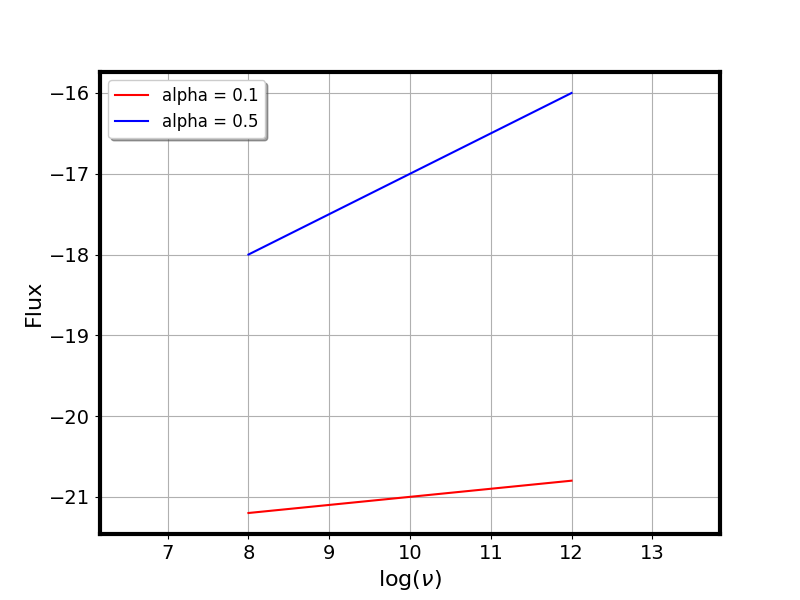

In [140]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
## spectral index plot
freq = np.array( [8, 9, 10, 11, 12] )

alph1 = 0.1
alph2 = 0.5
#alpha3 = np.linspace(-1,1,10)

C = 1.0E-22

F1  = np.log10(C)+(alph1)*freq #+freq
F2  = np.log10(C)+(alph2)*freq #+freq
#F3 =  np.log10(C)+(-alph3)*freq

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['axes.linewidth'] = 3
    
fig, ax = plt.subplots()

ax.plot(freq, F1, '-', c = 'red', markersize = 6, label = 'alpha = '+str(alph1))
ax.plot(freq, F2, '-', c = 'blue', markersize = 6, label = 'alpha = '+str(alph2))
#ax.plot(freq, F3+freq, '-', c = 'green', markersize = 6, label = 'alpha = '+str(alph3))
 
ax.set_xlim (7, 16)
ax.set_ylim (2, 14)
ax.set_ylim (-20, -10)

ax.axis('equal')
    
plt.xlabel( "log($\\nu$)",  fontsize = 16)
plt.xticks(fontsize = 14)
plt.ylabel('Flux',  fontsize = 16)
plt.yticks(fontsize = 14)
plt.grid(True)
plt.legend(loc='upper left', shadow=True, bbox_to_anchor = (0, 1), fontsize = 12, markerscale = 2) 


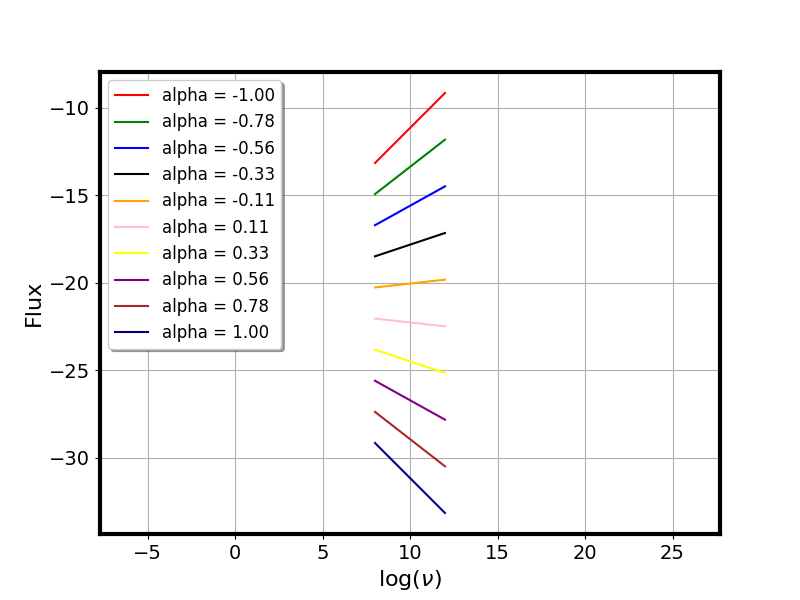

In [130]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

color = ['red', 'green', 'blue', 'black', 'orange','pink', 'yellow', 'purple', 'brown', 'navy']

freq = np.array( [8, 9, 10, 11, 12] )
alpha3 = np.linspace(-1,1,10)
C = 6.98E-22

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['axes.linewidth'] = 3
    
fig, ax = plt.subplots()

for i in range(0, 10):
    
    alpha3 = np.linspace(-1,1,10)

    #F1  = np.log10(C)+(-alph1+1)*freq #+freq
    #F2 = np.log10(C/10)+(-alph2)*freq
    F3 =  np.log10(C)+(-alpha3[i])*freq

    #ax.plot(freq, F1, '-', c = 'red', markersize = 6, label = 'alpha = '+str(alph1))
    #ax.plot(freq, F2, '-', c = 'blue', markersize = 6, label = 'alpha = '+str(alph2))
    ax.plot(freq, F3, '-', c = color[i], markersize = 6, label = 'alpha = %4.2f' %alpha3[i])
 
    ax.set_xlim (7, 16)
    ax.set_ylim (-20, -10)

    ax.axis('equal')
    
    plt.xlabel( "log($\\nu$)",  fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.ylabel('log(Flux)',  fontsize = 16)
    plt.yticks(fontsize = 14)
    plt.grid(True)
    plt.legend(loc='upper left', shadow=True, bbox_to_anchor = (0, 1), fontsize = 12, markerscale = 2) 
